In [1]:
"""
We simulate simplxes and relaxations of simplexes and compare MCMC with KDE sampler.
"""

'\nWe simulate simplxes and relaxations of simplexes and compare MCMC with KDE sampler.\n'

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from pathlib import Path
import pulp
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier 
from sklearn.mixture import GaussianMixture
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KernelDensity
from tqdm import tqdm
from pprint import pprint


from IPython.core.debugger import set_trace

In [3]:
ATOL = 1e-5
RTOL = 1.0000001e-3
DEFAULT_ATOL = 1e-8
DEFAULT_RTOL = 1.00000001e-5


def lp_solver(c_vec, A_mat, b_vec):
    prob = pulp.LpProblem('prob', pulp.LpMinimize)
    m, n = A_mat.shape
    x = [pulp.LpVariable('x{}'.format(ix)) for ix in range(n)]
    prob += pulp.lpSum([ ci * xi for ci, xi in zip(c_vec, x) ])
    for ix in range(m):
        prob += pulp.lpSum([ ai * xi for ai, xi in zip(A_mat[ix], x) ]) >= b_vec[ix], 'con{}'.format(ix)
    prob.solve(pulp.GLPK(msg=0))
    if prob.status in [1, -2, -3]:
        x_vec = np.array([ xi.varValue for xi in x ])
        return x_vec
    else:
        return None


def hit_n_run_init(c_vec, A_mat, b_vec):
    """
    Generate an initial decision in the interior of the feasible set.
    """
    n = len(c_vec)
    vtx0 = lp_solver(
        np.zeros(n),
        A_mat,
        b_vec + np.random.exponential(scale=1e-1)
    )
    vertices = [vtx0]
    for row in A_mat:
        vtx2 = lp_solver(
            row,
            A_mat,
            b_vec
        )
        if vtx2 is None:
            continue

        for vtx in vertices:
            if np.isclose(vtx, vtx2, rtol=RTOL, atol=ATOL).all() == True:
                continue

        vertices.append(vtx2)
        init_pt = np.mean(np.array(vertices), axis=0)
        if is_bd(A_mat, b_vec, init_pt, rtol=DEFAULT_RTOL, atol=DEFAULT_ATOL) == True:
            continue
        else:
            break
    if is_bd(A_mat, b_vec, init_pt, rtol=DEFAULT_RTOL, atol=DEFAULT_ATOL) == True:
        raise Exception('Convex combination is still boundary')
    return init_pt


def hit_n_run(c_vec, A_mat, b_vec, n_samples=200, verbose=True):
    """ Hit and Run Sampler:

        1. Sample current point x
        2. Generate a random direction r and make sure that x - r is feasible
        3. Solve max { lambda | A (x - lambda * r) >= b }
        4. Sample uniformly from [0, lambda]
    """
    m, n = A_mat.shape
    curr_pt = hit_n_run_init(c_vec, A_mat, b_vec)
    pts = [curr_pt]
    loop_sampler = range(n_samples)
    if verbose == True:
        loop_sampler = tqdm(loop_sampler)
    for _ in loop_sampler:
        direction = ( np.random.rand(n) - 0.5 )
        # push it a little bit to be feasible
        A_x = np.dot(A_mat, curr_pt) - b_vec 
        A_direction = np.dot(A_mat, direction)
        search_ub = pulp.LpProblem('search_ub', pulp.LpMaximize)
        gamma = pulp.LpVariable('gamma')
        # upper bound of search range
        search_ub += gamma
        for ix in range(m):
            search_ub += gamma * A_direction[ix] <= A_x[ix]
        search_ub.solve(pulp.GLPK(msg=0))
        if search_ub.status == 1:
            max_magnitude = gamma.varValue * 0.99
        elif search_ub.status in [-2, -3]:
            max_magnitude = 1e16
        else:
            max_magnitude = 0
        # lower bound of search range
        search_lb = pulp.LpProblem('search_lb', pulp.LpMinimize)
        gamma = pulp.LpVariable('gamma')
        search_lb += gamma
        for ix in range(m):
            search_lb += gamma * A_direction[ix] <= A_x[ix]
        search_lb.solve(pulp.GLPK(msg=0))
        if search_lb.status == 1:
            min_magnitude = gamma.varValue * 0.99
        elif search_lb.status in [-2, -3]:
            min_magnitude = -1e16
        else:
            min_magnitude = 0
        magnitude = np.random.uniform(low=min_magnitude, high=max_magnitude)
        curr_pt = curr_pt - magnitude * direction
        if is_feasible(A_mat, b_vec, curr_pt):
            pts.append(curr_pt)
    if len(pts) < min(0.1 * n_samples, 100):
        raise Exception(
            'Sampled {} points instead of {}'.format(len(pts), 0.5 * n_samples)
        )
    print('Sampled {} points for HR'.format(len(pts)))
    return pts


def direction_sample_helper(cons):
    """ Samples a random point from the unit ball then checks with
    the a vector that con'pt > 0
    """
    wrong_direction = 1
    n = len(cons[0])
    while wrong_direction == 1:
        pt = np.random.rand(n) - 0.5
        pt = pt / np.linalg.norm(pt)
        if all([np.dot(con, pt) >= 0 for con in cons]):
            wrong_direction = 0
    return pt


def direction_sample(A_mat, b_vec, bd_pt):
    """ First identifies the relevant constraint on the boundary,
    then calls sample helper.
    """
    delta = np.abs(np.dot(A_mat, bd_pt) - b_vec)
    cons = [ A_mat[ix] for ix in range(len(delta)) if delta[ix] < ATOL ]
    assert len(cons) > 0, 'This is not a boundary point.'
    #ind = np.argmin(delta)
    #val = np.min(delta)
    #if val > ATOL:
    #    print('No boundary, gap is {}'.format(val))
    #con = A_mat[ind]
    return direction_sample_helper(cons)


def get_next_bd_pt(A_mat, b_vec, bd_pt, dir_pt):
    """ First removes boundary constraints, then finds nearest
    boundary.
    """
    weights = np.array([(bi - np.dot(ai, bd_pt)) / np.dot(ai, dir_pt) for ai, bi in zip(A_mat, b_vec)])
    if all(weights <= 0):
        weight = 0
    else:
        weights[weights <= 0] = 1e12
        weight = min(weights)
    tmp = bd_pt + weight * dir_pt
    if is_bd(A_mat, b_vec, tmp) == False:
        print('not bd.')

    return bd_pt + weight * dir_pt


def shuffle_A_b(A_mat, b_vec):
    """
    Shuffle the rows of the A matrix and b vector accordingly.
    """
    m, n = A_mat.shape
    A_new = np.zeros((m, n))
    b_new = np.zeros(m)
    reorder = np.random.permutation(list(range(m)))
    for i, j in enumerate(reorder):
        A_new[i] = A_mat[j]
        b_new[i] = b_vec[j]
    return A_new, b_new


def shake_n_bake_infeas(A_mat, b_vec, init_pt, n_samples=10, scale=1, b_hid=[0], verbose=True):
    """
    1. randomly sample direction vector (r)
    2. randomly sample magnitude (xi)
    3. add infeasible point (y - xi * r, y)
    4. get next boundary point
    """
    if all(b_hid) == 0:
        b_hid = b_vec
    dataset = []
    bd_pt = init_pt
    loop_sampler = range(n_samples)
    if verbose == True:
        loop_sampler = tqdm(loop_sampler)
    for ix in loop_sampler:
        r = direction_sample(A_mat, b_vec, bd_pt)
        xi = np.random.exponential(scale=scale)
        infeas_pt = bd_pt - xi * r
        if is_feasible(A_mat, b_hid, infeas_pt) == False:
            dataset.append(infeas_pt)
            assert is_bd(A_mat, b_vec, bd_pt), 'sb using not bd.'
        else:
            print('shake n bake found feasible pt.')
            # pass
        bd_pt = get_next_bd_pt(A_mat, b_vec, bd_pt, r)
    return np.array(dataset)


def shake_n_bake_init(c_vec, A_mat, b_vec):
    m, n = A_mat.shape
    init_pt = lp_solver(c_vec, A_mat, b_vec)
    if init_pt is None:
        raise Exception('Could not initialize shake_n_bake')
    return init_pt


def is_feasible(A_mat, b_vec, pt, tol=1e-5):
    # Assuming inequality form
    true_tol = np.linalg.norm(b_vec) * tol
    if (np.dot(A_mat, pt) >= b_vec - true_tol).all():
        return True
    else:
        return False


def is_bd(A_mat, b_vec, pt, rtol=RTOL, atol=ATOL):
    # Assuming inequality form
    if is_feasible(A_mat, b_vec, pt) == False:
        return False
    if np.isclose(np.dot(A_mat, pt), b_vec, rtol=rtol, atol=atol).any():
        return True
    else:
        return False

    
def mcmc_test_set(A_mat, b_vec, n_samples=200, scale=1, verbose=True):
    """
    Will generate feasible points using hitnrun.
    and infeasible points using shakenbake and projection.
    """
    c_vec = np.random.randn(len(b_vec))
    A_mat, b_vec = shuffle_A_b(A_mat, b_vec)
    feas_n_samples = int(n_samples / 2)
    mcmc_n_samples = int(n_samples / 2) 
    feas_pts = hit_n_run(
        c_vec,
        A_mat,
        b_vec,
        n_samples=feas_n_samples,
        verbose=verbose,
    )
    feas_pts = np.array(feas_pts)

    init_pt = shake_n_bake_init(c_vec, A_mat, b_vec)
    mcmc_infeas_pts = shake_n_bake_infeas(
        A_mat,
        b_vec,
        init_pt,
        n_samples=mcmc_n_samples,
        scale=scale,
        verbose=verbose,
    )
    
    X_test = np.vstack([feas_pts, mcmc_infeas_pts])
    y_test = []
    for xi in X_test:
        y_test.append(int(is_feasible(A_mat, b_vec, xi)))
    print(
        'Generated {} feasible and {} infeasible pts for testing.'.format(
            np.sum(y_test),
            len(y_test) - np.sum(y_test),
        )
    )
    return X_test, np.array(y_test)

In [4]:
def get_simplex_constraints(n=2, size=-1, scale=1):
    A_mat = [ -1 * np.ones(n) ]
    for ix in range(n):
        row = np.zeros(n)
        row[ix] = 1
        A_mat.append(row)
    b_vec = np.zeros(n+1)
    b_vec[0] = size
    b_relax = b_vec - np.random.exponential(scale=scale)
    return np.array(A_mat), b_vec, b_relax


def train_and_test_classifier(feas_pts, infeas_pts, X_test, y_test, model=SVC, verbose=True):
    X_train = np.vstack((feas_pts, infeas_pts))
    feas_labels = np.array([np.ones(len(feas_pts))]).T
    infeas_labels = np.array([np.zeros(len(infeas_pts))]).T
    y_train = np.vstack(
        (feas_labels, infeas_labels)
    ).T[0]
    clf = model()
    clf.fit(X_train, y_train)
    acc = clf.score(X_test, y_test)
    tn, fp, fn, tp = confusion_matrix(y_test, clf.predict(X_test)).ravel()
    if verbose == True:
        print('Test set score = {}'.format(acc))
        print('TP = {} FP = {}'.format(tp, fp))
        print('FN = {} TN = {}'.format(fn, tn))

    return acc


def train_and_test_kde(feas_pts, X_test, y_test, verbose=True):
    pca = PCA(0.95)
    X_train = pca.fit_transform(feas_pts)
    
    # use grid search cross-validation to optimize the bandwidth
    accs = []
    n_bandwidths = [0.005, 0.01, 0.1, 0.5, 1, 5, 10, 50, 100 ]
    for bw in n_bandwidths:
        kde = KernelDensity(bandwidth=bw)
        try:
            kde.fit(X_train)
            
            min_pred = np.min(-1 / kde.score_samples(X_train))
            y_pred = -1 / kde.score_samples(pca.transform(X_test))
            y_pred[y_pred > min_pred] = 1
            y_pred[y_pred < min_pred] = 0
            
            acc = 1 - np.mean(np.abs(y_test - y_pred))
            tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
            if verbose == True:
                print('Test set score = {}'.format(acc))
                print('TP = {} FP = {}'.format(tp, fp))
                print('FN = {} TN = {}'.format(fn, tn))
            accs.append(acc)
        except Exception as inst:
            print(inst)
    return np.max(accs)


def plot_2d_kde(feas_pts):
    pca = PCA(0.95)
    X_train = pca.fit_transform(feas_pts)
    kde = KernelDensity(bandwidth=0.1)
    kde.fit(X_train)
    min_pred = np.min(-1 / kde.score_samples(X_train))
    
    xs, ys = np.meshgrid(np.arange(-7, 7, 0.1), np.arange(-7, 7, 0.1))
    pred_feas = np.zeros((len(xs), len(ys)))
    for i in range(len(xs)):
        for j in range(len(ys)):
            pred_feas[i, j] = -1 / kde.score_samples(pca.transform([np.array([xs[i, j], ys[i, j]])]))
    pred_feas[pred_feas > min_pred] = 1
    pred_feas[pred_feas < min_pred] = 0
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.contour(xs, ys, pred_feas)
    ax.tick_params(direction='in')
    ax.grid(True, ls='--', alpha=0.1)
    ax.set(
        xlabel='x', 
        ylabel='y', 
    )


def plot_2d_results(feas_pts, mcmc_infeas_pts):
    feas_pts = feas_pts.T
    mcmc_infeas_pts = mcmc_infeas_pts.T
    
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.scatter(feas_pts[0], feas_pts[1])
    ax.scatter(mcmc_infeas_pts[0], mcmc_infeas_pts[1])
    ax.tick_params(direction='in')
    ax.grid(True, ls='--', alpha=0.1)
    ax.set(
        xlabel='x', 
        ylabel='y', 
    )    

    
def experiment_simplex_2d(n_samples=200, test_n_samples=200, scale=1):
    n = 2
    A_mat, b_vec, b_relax = get_simplex_constraints(size=-5, scale=scale)
    # Generate feasible points via hit n run
    feas_pts = hit_n_run(np.random.randn(n), A_mat, b_vec, n_samples=n_samples)
    feas_pts = np.array(feas_pts)
    feas_check = [ is_feasible(A_mat, b_vec, pt) == True for pt in feas_pts ]
    assert all(feas_check), 'Generated infeasible point instead of feasible'
    n_samples = len(feas_pts)
    # generate SB data
    print('Running SB sampler ...')
    init_pt = shake_n_bake_init(np.random.randn(n), A_mat, b_relax)
    mcmc_infeas_pts = shake_n_bake_infeas(
        A_mat,
        b_relax,
        init_pt,
        n_samples=n_samples,
        scale=(scale),
        b_hid=b_vec,
    )
    feas_check = [ is_feasible(A_mat, b_vec, pt) == False for pt in mcmc_infeas_pts ]
    assert all(feas_check), 'Generated feasible point instead of infeasible'
    print('MCMC {} points'.format(len(mcmc_infeas_pts)))
    # plot results
    plot_2d_results(feas_pts, mcmc_infeas_pts)
    plot_2d_kde(feas_pts)
    # generate testing data
    X_test, y_test = mcmc_test_set(A_mat, b_vec, test_n_samples, scale=1)
    train_and_test_kde(feas_pts, X_test, y_test)
    train_and_test_classifier(feas_pts, mcmc_infeas_pts, X_test, y_test, RandomForestClassifier)
    #train_and_test_classifier(feas_pts, mcmc_infeas_pts, X_test, y_test, AdaBoostClassifier)
    #train_and_test_classifier(feas_pts, mcmc_infeas_pts, X_test, y_test, GradientBoostingClassifier)


In [ ]:
experiment_simplex_2d(n_samples=500, test_n_samples=200, scale=1)

In [ ]:
"""
What are the experiments that I should run?

- n dimensions
- scale?
- size of 
"""

In [ ]:
def experiment_sweep_scale():
    """
    Evaluates the effect of the size of the relaxation relative to the 
    real hidden feasible set. If the relaxation is tighter, then the MCMC-based
    classifier works well (and often better than the alternative). However,
    if the relaxation is loose, then the MCMC does not work well. This makes
    sense, if you have a loose relaxation, there is lots of space to generate a
    separation so you are more likely to build a weaker barrier. The KDE-based
    approach does not use the relaxation at all, so it is always consistent.
    """
    scales = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    n = 2
    n_samples = 1000
    test_n_samples = 1000
    n_tries = 10
    results = {}
    
    for scale_param in scales:
        print('*'*80)
        print('Testing scale = {}'.format(scale_param))
        print('*'*80)
        A_mat, b_vec, b_relax = get_simplex_constraints(size=-1, scale=0)
        b_relax = b_vec - scale_param
        _try = 0
        kde_accs = []
        snb_accs = []
        while _try < n_tries:
            try:
                # Generate feasible points via hit n run
                feas_pts = hit_n_run(
                    np.random.randn(n),
                    A_mat,
                    b_vec,
                    n_samples=n_samples,
                    verbose=False
                )
                feas_pts = np.array(feas_pts)
                feas_check = [ is_feasible(A_mat, b_vec, pt) == True for pt in feas_pts ]
                assert all(feas_check), 'Generated infeasible point instead of feasible'
                n_samples = len(feas_pts)

                init_pt = shake_n_bake_init(np.random.randn(n), A_mat, b_relax)
                mcmc_infeas_pts = shake_n_bake_infeas(
                    A_mat,
                    b_relax,
                    init_pt,
                    n_samples=n_samples,
                    scale=1,
                    b_hid=b_vec,
                    verbose=False,
                )
                feas_check = [
                    is_feasible(A_mat, b_vec, pt) == False for pt in mcmc_infeas_pts
                ]
                assert all(feas_check), 'Generated feasible point instead of infeasible'

                X_test, y_test = mcmc_test_set(
                    A_mat,
                    b_vec,
                    test_n_samples,
                    scale=1,
                    verbose=False
                )
                kde_acc = train_and_test_kde(
                    feas_pts,
                    X_test,
                    y_test,
                    verbose=False
                )
                snb_acc = train_and_test_classifier(
                    feas_pts,
                    mcmc_infeas_pts,
                    X_test,
                    y_test,
                    RandomForestClassifier,
                    verbose=False
                )
                kde_accs.append(kde_acc)
                snb_accs.append(snb_acc)
                _try += 1
            except Exception as inst:
                print(inst)
            results[scale_param] = {
                    'kde_acc': np.mean(kde_accs),
                    'snb_acc': np.mean(snb_accs),
                }

    pprint(results)
    xs = list(results.keys())
    ys_kde = list(results[x]['kde_acc'] for x in results)
    ys_snb = list(results[x]['snb_acc'] for x in results)
    
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.plot(xs, ys_kde, label='kde')
    ax.plot(xs, ys_snb, label='snb')
    ax.tick_params(direction='in')
    ax.grid(True, ls='--', alpha=0.1)
    ax.set(
        xlabel='Size of relaxation (b_relax)', 
        ylabel='Mean accuracy', 
    )
    ax.legend()

experiment_sweep_scale()

In [ ]:
def experiment_sweep_hidden_poly_size():
    """
    Evaluates the effect of the size of the hidden feasible set. This is
    more for personal interest. We fix the size of the relaxation relative
    to the hidden set and scale the hidden set. We should observe that the 
    MCMC-classifier has a fixed performance, but the KDE-classifier perhaps
    gets better as we increase size? Let's just fix scale at 1?
    
    Results: MCMC stays fixed at 90% accuracy, but KDE decreases as we
    increase size. As expected.
    """
    hidden_sizes = [-0.1, -1, -10, -50, -100]
    scale = 1
    n = 2
    n_samples = 1000
    test_n_samples = 1000
    n_tries = 10
    results = {}
    
    for size_param in hidden_sizes:
        print('*'*80)
        print('Testing size = {}'.format(size_param))
        print('*'*80)
        _try = 0
        kde_accs = []
        snb_accs = []
        while _try < n_tries:
            try:
                A_mat, b_vec, b_relax = get_simplex_constraints(size=size_param, scale=scale)
                # Generate feasible points via hit n run
                feas_pts = hit_n_run(
                    np.random.randn(n),
                    A_mat,
                    b_vec,
                    n_samples=n_samples,
                    verbose=False
                )
                feas_pts = np.array(feas_pts)
                feas_check = [ is_feasible(A_mat, b_vec, pt) == True for pt in feas_pts ]
                assert all(feas_check), 'Generated infeasible point instead of feasible'
                n_samples = len(feas_pts)

                init_pt = shake_n_bake_init(np.random.randn(n), A_mat, b_relax)
                mcmc_infeas_pts = shake_n_bake_infeas(
                    A_mat,
                    b_relax,
                    init_pt,
                    n_samples=n_samples,
                    scale=1,
                    b_hid=b_vec,
                    verbose=False,
                )
                feas_check = [
                    is_feasible(A_mat, b_vec, pt) == False for pt in mcmc_infeas_pts
                ]
                assert all(feas_check), 'Generated feasible point instead of infeasible'

                X_test, y_test = mcmc_test_set(
                    A_mat,
                    b_vec,
                    test_n_samples,
                    scale=1,
                    verbose=False
                )
                kde_acc = train_and_test_kde(
                    feas_pts,
                    X_test,
                    y_test,
                    verbose=False
                )
                snb_acc = train_and_test_classifier(
                    feas_pts,
                    mcmc_infeas_pts,
                    X_test,
                    y_test,
                    RandomForestClassifier,
                    verbose=False
                )
                kde_accs.append(kde_acc)
                snb_accs.append(snb_acc)
                _try += 1
            except Exception as inst:
                print(inst)
            results[-1 * size_param] = {
                    'kde_acc': np.mean(kde_accs),
                    'snb_acc': np.mean(snb_accs),
                }

    pprint(results)
    xs = list(results.keys())
    ys_kde = list(results[x]['kde_acc'] for x in results)
    ys_snb = list(results[x]['snb_acc'] for x in results)
    
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.semilogx(xs, ys_kde, label='kde')
    ax.semilogx(xs, ys_snb, label='snb')
    ax.tick_params(direction='in')
    ax.grid(True, ls='--', alpha=0.1)
    ax.set(
        xlabel='Size of feasible set (b_vec)', 
        ylabel='Mean accuracy', 
    )
    ax.legend()
    
experiment_sweep_hidden_poly_size()

********************************************************************************
R^4
********************************************************************************
Sampled 1001 points for HR
Sampled 501 points for HR
Generated 501 feasible and 500 infeasible pts for testing.


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Sampled 1002 points for HR
Sampled 501 points for HR
Generated 501 feasible and 500 infeasible pts for testing.


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Sampled 1003 points for HR
shake n bake found feasible pt.
Sampled 501 points for HR
Generated 501 feasible and 500 infeasible pts for testing.


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Sampled 1004 points for HR
shake n bake found feasible pt.
Sampled 501 points for HR
Generated 501 feasible and 500 infeasible pts for testing.


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Sampled 1005 points for HR
Sampled 501 points for HR
Generated 501 feasible and 500 infeasible pts for testing.


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Sampled 1006 points for HR
Sampled 501 points for HR
Generated 501 feasible and 500 infeasible pts for testing.


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Sampled 1007 points for HR
Sampled 501 points for HR
Generated 501 feasible and 500 infeasible pts for testing.


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Sampled 1008 points for HR
shake n bake found feasible pt.
shake n bake found feasible pt.
Sampled 501 points for HR
Generated 501 feasible and 500 infeasible pts for testing.


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Sampled 1009 points for HR
Sampled 501 points for HR
Generated 501 feasible and 500 infeasible pts for testing.


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Sampled 1010 points for HR
Sampled 501 points for HR
Generated 501 feasible and 500 infeasible pts for testing.


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


********************************************************************************
R^8
********************************************************************************
Sampled 1011 points for HR
Sampled 501 points for HR
Generated 501 feasible and 500 infeasible pts for testing.


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Sampled 1012 points for HR
Sampled 501 points for HR
Generated 501 feasible and 500 infeasible pts for testing.


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Sampled 1013 points for HR
Sampled 501 points for HR
Generated 501 feasible and 500 infeasible pts for testing.


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Sampled 1014 points for HR
Convex combination is still boundary
Sampled 1015 points for HR
Sampled 501 points for HR
Generated 501 feasible and 500 infeasible pts for testing.


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Sampled 1016 points for HR
Sampled 501 points for HR
Generated 501 feasible and 500 infeasible pts for testing.


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Sampled 1017 points for HR
Sampled 501 points for HR
shake n bake found feasible pt.
Generated 501 feasible and 499 infeasible pts for testing.


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Sampled 1018 points for HR
shake n bake found feasible pt.
Sampled 501 points for HR
Generated 501 feasible and 500 infeasible pts for testing.


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Sampled 1019 points for HR
Sampled 501 points for HR
Generated 501 feasible and 500 infeasible pts for testing.


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Sampled 1020 points for HR
Sampled 501 points for HR
Generated 501 feasible and 500 infeasible pts for testing.


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Convex combination is still boundary
Sampled 1021 points for HR
Sampled 501 points for HR
Generated 501 feasible and 500 infeasible pts for testing.


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


********************************************************************************
R^16
********************************************************************************
Sampled 1022 points for HR
Sampled 501 points for HR
Generated 501 feasible and 500 infeasible pts for testing.


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Convex combination is still boundary
Sampled 1023 points for HR
Sampled 501 points for HR
shake n bake found feasible pt.
Generated 501 feasible and 499 infeasible pts for testing.


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Sampled 1024 points for HR
Sampled 501 points for HR
Generated 501 feasible and 500 infeasible pts for testing.


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Sampled 1025 points for HR
Sampled 501 points for HR
Generated 501 feasible and 500 infeasible pts for testing.


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Sampled 1026 points for HR
Sampled 501 points for HR
Generated 501 feasible and 500 infeasible pts for testing.


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Sampled 1027 points for HR
shake n bake found feasible pt.
Sampled 501 points for HR
Generated 501 feasible and 500 infeasible pts for testing.


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Sampled 1028 points for HR
Sampled 501 points for HR
Generated 501 feasible and 500 infeasible pts for testing.


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Sampled 1029 points for HR
Sampled 501 points for HR
Generated 501 feasible and 500 infeasible pts for testing.


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Sampled 1030 points for HR
Sampled 501 points for HR
Generated 501 feasible and 500 infeasible pts for testing.


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Sampled 1031 points for HR
Sampled 501 points for HR
shake n bake found feasible pt.
Generated 501 feasible and 499 infeasible pts for testing.


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


********************************************************************************
R^32
********************************************************************************
Sampled 1032 points for HR
shake n bake found feasible pt.
Sampled 501 points for HR
Generated 501 feasible and 500 infeasible pts for testing.


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Sampled 1033 points for HR
Sampled 501 points for HR
Generated 501 feasible and 500 infeasible pts for testing.


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Sampled 1034 points for HR
Sampled 501 points for HR
Generated 501 feasible and 500 infeasible pts for testing.


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Sampled 1035 points for HR
Sampled 501 points for HR
Generated 501 feasible and 500 infeasible pts for testing.


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Sampled 1036 points for HR
Sampled 501 points for HR
Generated 501 feasible and 500 infeasible pts for testing.


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Sampled 1037 points for HR
Sampled 501 points for HR
Generated 501 feasible and 500 infeasible pts for testing.


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Sampled 1038 points for HR
Sampled 501 points for HR
Generated 501 feasible and 500 infeasible pts for testing.


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Sampled 1039 points for HR
Sampled 501 points for HR
Generated 501 feasible and 500 infeasible pts for testing.


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Sampled 1040 points for HR
shake n bake found feasible pt.
Sampled 501 points for HR
Generated 501 feasible and 500 infeasible pts for testing.


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Sampled 1041 points for HR
Sampled 501 points for HR
Generated 501 feasible and 500 infeasible pts for testing.


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


********************************************************************************
R^64
********************************************************************************
Sampled 1042 points for HR
Sampled 501 points for HR
Generated 501 feasible and 500 infeasible pts for testing.


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Sampled 1043 points for HR
Sampled 501 points for HR
Generated 501 feasible and 500 infeasible pts for testing.


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Sampled 1044 points for HR
Sampled 501 points for HR
Generated 501 feasible and 500 infeasible pts for testing.


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Sampled 1045 points for HR
shake n bake found feasible pt.
Sampled 501 points for HR
Generated 501 feasible and 500 infeasible pts for testing.


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Sampled 1046 points for HR
Sampled 501 points for HR
Generated 501 feasible and 500 infeasible pts for testing.


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Sampled 1047 points for HR
Sampled 501 points for HR
Generated 501 feasible and 500 infeasible pts for testing.


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Sampled 1048 points for HR
Sampled 501 points for HR
Generated 501 feasible and 500 infeasible pts for testing.


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Sampled 1049 points for HR
Sampled 501 points for HR
Generated 501 feasible and 500 infeasible pts for testing.


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Sampled 1050 points for HR
Sampled 501 points for HR
Generated 501 feasible and 500 infeasible pts for testing.


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Sampled 1051 points for HR
Sampled 501 points for HR
Generated 501 feasible and 500 infeasible pts for testing.


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


********************************************************************************
R^128
********************************************************************************
Sampled 1052 points for HR
Sampled 501 points for HR
Generated 501 feasible and 500 infeasible pts for testing.


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Sampled 1053 points for HR
Sampled 501 points for HR
Generated 501 feasible and 500 infeasible pts for testing.


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Sampled 1054 points for HR
Sampled 501 points for HR
shake n bake found feasible pt.
Generated 501 feasible and 499 infeasible pts for testing.


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Sampled 1055 points for HR
shake n bake found feasible pt.
Sampled 501 points for HR
Generated 501 feasible and 500 infeasible pts for testing.


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Sampled 1056 points for HR
Sampled 501 points for HR
Generated 501 feasible and 500 infeasible pts for testing.


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Sampled 1057 points for HR
Sampled 501 points for HR
Generated 501 feasible and 500 infeasible pts for testing.


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Sampled 1058 points for HR
Sampled 501 points for HR
Generated 501 feasible and 500 infeasible pts for testing.


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Sampled 1059 points for HR
Sampled 501 points for HR
Generated 501 feasible and 500 infeasible pts for testing.


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Sampled 1060 points for HR
Sampled 501 points for HR
Generated 501 feasible and 500 infeasible pts for testing.


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Sampled 1061 points for HR
shake n bake found feasible pt.
Sampled 501 points for HR
Generated 501 feasible and 500 infeasible pts for testing.


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


********************************************************************************
R^256
********************************************************************************
Sampled 1062 points for HR
Sampled 501 points for HR
Generated 501 feasible and 500 infeasible pts for testing.


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Sampled 1063 points for HR
Sampled 501 points for HR
Generated 501 feasible and 500 infeasible pts for testing.


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Sampled 1064 points for HR
Sampled 501 points for HR
shake n bake found feasible pt.
Generated 501 feasible and 499 infeasible pts for testing.


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Sampled 1065 points for HR
Sampled 501 points for HR
Generated 501 feasible and 500 infeasible pts for testing.


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Sampled 1066 points for HR
Sampled 501 points for HR
Generated 501 feasible and 500 infeasible pts for testing.


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Sampled 1067 points for HR
Sampled 501 points for HR
Generated 501 feasible and 500 infeasible pts for testing.


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Sampled 1068 points for HR
Sampled 501 points for HR
Generated 501 feasible and 500 infeasible pts for testing.


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Sampled 1069 points for HR
Sampled 501 points for HR
Generated 501 feasible and 500 infeasible pts for testing.


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Sampled 1070 points for HR
Convex combination is still boundary
Sampled 1071 points for HR
Sampled 501 points for HR
Generated 501 feasible and 500 infeasible pts for testing.


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Sampled 1072 points for HR
Sampled 501 points for HR
Generated 501 feasible and 500 infeasible pts for testing.


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


{4: {'kde_acc': 0.8606393606393606, 'snb_acc': 0.9283716283716285},
 8: {'kde_acc': 0.860024175824176, 'snb_acc': 0.9510466533466533},
 16: {'kde_acc': 0.858211988011988, 'snb_acc': 0.9350517482517482},
 32: {'kde_acc': 0.8683316683316683, 'snb_acc': 0.9335664335664335},
 64: {'kde_acc': 0.85994005994006, 'snb_acc': 0.9442557442557444},
 128: {'kde_acc': 0.8581279720279721, 'snb_acc': 0.9374560439560439},
 256: {'kde_acc': 0.8616241758241758, 'snb_acc': 0.9446509490509492}}


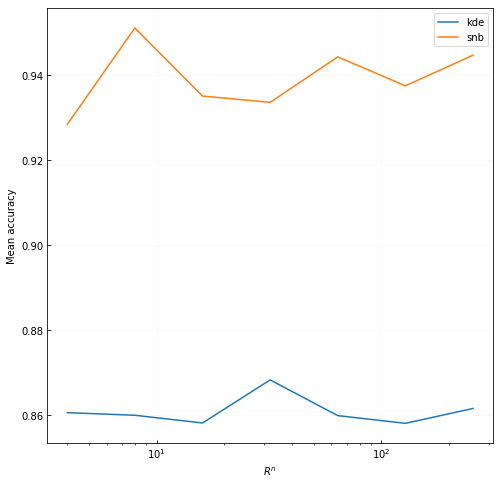

In [7]:
def experiment_sweep_Rn():
    """
    Compares MCMC and KDE on simplex with a sweep over dimensions.
    Expecting to see the KDE completely fall apart at higher dimensions.
    
    Results:
    - Rn = [2, 4, 6, 8, 10, 12, 14,]: no real changes, MCMC and KDE are
    consistently 90% and 80% respectively.
    """
    Rn = [4, 8, 16, 32, 64, 128, 256]
    scale = 1
    n_samples = 1000
    test_n_samples = 1000
    n_tries = 10
    results = {}
    
    for n in Rn:
        print('*'*80)
        print('R^{}'.format(n))
        print('*'*80)
        _try = 0
        kde_accs = []
        snb_accs = []
        while _try < n_tries:
            try:
                A_mat, b_vec, b_relax = get_simplex_constraints(scale=scale)
                # Generate feasible points via hit n run
                feas_pts = hit_n_run(
                    np.random.randn(n),
                    A_mat,
                    b_vec,
                    n_samples=n_samples,
                    verbose=False
                )
                feas_pts = np.array(feas_pts)
                feas_check = [ is_feasible(A_mat, b_vec, pt) == True for pt in feas_pts ]
                assert all(feas_check), 'Generated infeasible point instead of feasible'
                n_samples = len(feas_pts)

                init_pt = shake_n_bake_init(np.random.randn(n), A_mat, b_relax)
                mcmc_infeas_pts = shake_n_bake_infeas(
                    A_mat,
                    b_relax,
                    init_pt,
                    n_samples=n_samples,
                    scale=1,
                    b_hid=b_vec,
                    verbose=False,
                )
                feas_check = [
                    is_feasible(A_mat, b_vec, pt) == False for pt in mcmc_infeas_pts
                ]
                assert all(feas_check), 'Generated feasible point instead of infeasible'

                X_test, y_test = mcmc_test_set(
                    A_mat,
                    b_vec,
                    test_n_samples,
                    scale=1,
                    verbose=False
                )
                kde_acc = train_and_test_kde(
                    feas_pts,
                    X_test,
                    y_test,
                    verbose=False
                )
                snb_acc = train_and_test_classifier(
                    feas_pts,
                    mcmc_infeas_pts,
                    X_test,
                    y_test,
                    RandomForestClassifier,
                    verbose=False
                )
                kde_accs.append(kde_acc)
                snb_accs.append(snb_acc)
                _try += 1
            except Exception as inst:
                print(inst)
            results[n] = {
                    'kde_acc': np.mean(kde_accs),
                    'snb_acc': np.mean(snb_accs),
                }

    pprint(results)
    xs = list(results.keys())
    ys_kde = list(results[x]['kde_acc'] for x in results)
    ys_snb = list(results[x]['snb_acc'] for x in results)
    
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.semilogx(xs, ys_kde, label='kde')
    ax.semilogx(xs, ys_snb, label='snb')
    ax.tick_params(direction='in')
    ax.grid(True, ls='--', alpha=0.1)
    ax.set(
        xlabel='$R^n$', 
        ylabel='Mean accuracy', 
    )
    ax.legend()
    
experiment_sweep_Rn()